In [1]:
# ! pip install gym-super-mario-bros==7.3.0

In [2]:
# ! apt update
# ! apt install xvfb
# ! pip install pyvirtualdisplay

In [3]:
# ! pip uninstall gym

In [4]:
! pip install gym==0.26.2

In [5]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gymは、Open AIのRL用ツールキットです
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# OpenAI Gym用に使うNES エミュレーター
from nes_py.wrappers import JoypadSpace

#OpenAI Gymのスーパー・マリオ・ブラザーズの環境
import gym_super_mario_bros

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <3EF8D74C-9F11-3C9E-85DB-9E76BCCBE7A0> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <598DDE6B-5A2E-3301-B9C5-9034AEC256A9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 強化学習：RLの各種用語整理
環境：
エージェントが相互作用をする対象であり、また、エージェントが学習を行う対象でもある世界です。

行動 
 :
エージェントが環境に対して行う働きかけです。
エージェントが取りうる全ての行動の集合を「行動空間」と呼びます。

状態 
：
環境の現在の状況です。
環境が成り得る全ての状態の集合を「状態空間」と呼びます。

報酬 
：
報酬は、環境からエージェントに対するフィードバックです。
この報酬によってエージェントは学習し、行動選択を変えていきます。
複数のタイムステップにわたる報酬の集合は、利得と呼ばれます。

行動価値関数 
 :
 は、状態 
の時にエージェントが任意の行動
を取り、さらに将来のタイムステップにわたって利得を最大化する行動を取った場合の、利得の期待値を返す関数です。
すなわち、
 はある状態 
での行動
の「質」を表していると言えます。
この関数を近似した関数を作成することで、次の行動の「質」を評価して行動選択が行えるようになります。

In [6]:
import gym
import gym_super_mario_bros
import nes_py
import pkg_resources

# print(f"gym version: {gym.__version__}")
# print(f"gym_super_mario_bros version: {pkg_resources.get_distribution('gym_super_mario_bros').version}")
# print(f"nes_py version: {nes_py.__version__}")

In [7]:
# ! pip install --upgrade gym


In [8]:
# スーパー・マリオの環境を初期化
# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v3")

# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = gym.make('SuperMarioBros-v1', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, truncated, info = env.step(action = 0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v1 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


2024-06-20 20:22:34.799 Python[38440:7370589] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/s_/w4ncchnj77322v1x6dslwsq40000gn/T/org.python.python.savedState
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## env.step の説明

### 返り値

- `obs`: (240, 256, 3)
  - 240×256の3チャンネルで画面を作成している
- `reward`: float型
- `done`: bool型
- `truncated`: bool型
- `info`: dict型

### info の内容

| キー | 値 | 説明 |
|------|-----|------|
| 'coins' | 0 | 現在のコイン数 |
| 'flag_get' | False | フラッグ（ゴール）に到達していない |
| 'life' | 2 | 残りライフ数 |
| 'score' | 0 | 現在のスコア |
| 'stage' | 1 | 現在のステージ |
| 'status' | 'small' | マリオの状態（小さい状態） |
| 'time' | 400 | 残り時間 |
| 'world' | 1 | 現在のワールド |
| 'x_pos' | 40 | ゲーム内でのX座標位置 |
| 'x_pos_screen' | 40 | 画面上でのX座標位置 |
| 'y_pos' | 79 | Y座標位置 |



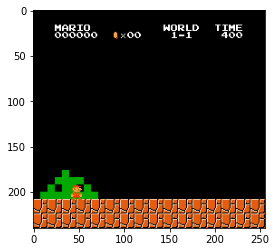

In [9]:
import matplotlib.pyplot as plt
plt.imshow(next_state)

## 今の所，RGB値はAgentにとって必要のないものなのでこれをラッパーしていく

In [10]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """スキップした後のフレームのみを返す"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """行動を繰り返し、報酬を合計する"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # 報酬を蓄積し、同じ行動を繰り返す
            # next_state, reward, done, info = self.env.step(action)
            # result = self.env.step(action)
            # print(f"env.step() returned {len(result)} values: {result}")
            next_state, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return next_state, total_reward, done, truncated, info


# グレースケールに変換するラッパー
# 変更後　next_state.shape: (240, 256, 3) -> (1, 240, 256)
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # [H, W, C] のarrayを、[C, H, W] のtensorに変換
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# 環境にWrapperを適用
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [11]:
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


In [12]:
# class Mario:
#     def __init__():
#         pass

#     def act(self, state):
#         """状態が与えられたとき、ε-greedy法に従って行動を選択します"""
#         pass

#     def cache(self, experience):
#         """経験をメモリに追加します"""
#         pass

#     def recall(self):
#         """記憶からの経験のサンプリングします"""
#         pass

#     def learn(self):
#         """経験のデータのバッチで、オンラインに行動価値関数(Q)を更新します"""
#         pass

# Marioの動きの実装

# MarioのAction定義

In [13]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # 最適な行動を予測するマリオ用のDNN「訓練」セクションで実装
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  #  Netを保存するまでの実験ステップの数です

    def act(self, state):
        """
        状態が与えられると、ε-greedy法で行動を選択し、ステップの値を更新

        Inputs:
            state(LazyFrame):現在の状態における一つの観測オブジェクトで、(state_dim)次元となる
        Outputs:
            action_idx (int): マリオが取る行動を示す整数値
        """
        # 探索（EXPLORE）
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # 活用（EXPLOIT）
        else:
            # 入力された状態をnupmy配列に変換
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            # 最適な行動を選択
            action_idx = torch.argmax(action_values, axis=1).item()

        # exploration_rateを減衰させます
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # ステップを+1します
        self.curr_step += 1
        return action_idx

# 記憶の保存と呼び出し

In [14]:
class Mario(Mario):  # さきほどのクラスのサブクラス
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        経験をself.memory (replay buffer)に保存

        Inputs:
            state (LazyFrame),
            next_state (LazyFrame),
            action (int),
            reward (float),
            done(bool))
        """
        print(type(state), state)
        # state = state.__array__()
        # next_state = next_state.__array__()
        state = np.array(state[0])
        next_state = np.array(next_state[0])

        # GPUを使うかどうか
        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        メモリから経験のバッチを取得します
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

# 訓練

マリオの強化学習アルゴリズムには、DDQNアルゴリズムを使用します。

#### DDQNの特徴

DDQNでは、以下の2つのConvNetを使用します：

1. Q_online
2. Q_target

これらのConvNetは、それぞれ独立して最適な行動価値関数を近似します。

#### 実装の詳細

本実装では：

- Q_online と Q_target は同じ特徴生成器を使用
- ただし、分類器としては別々に更新される

#### パラメータの更新方法

1. Q_target のパラメータ：
   - 逆伝播の際に更新されないよう、固定される

2. Q_target の更新方法：
   - Q_online の値と定期的に同期される

このように、Q_target は間接的に更新されます。

In [15]:
class MarioNet(nn.Module):
    """
    単純なCNN構造とし、以下の通りです
    input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output

    DDQNでは行動の価値がオンラインとターゲットの二つで計算される
    まず最初にオンラインネットワークで行動を選択
    次にターゲットネットワークで行動の価値を計算
    """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        # inputの次元をチェック
        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target のパラメータは固定されます
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

# TD 推論値とTDターゲット


In [16]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [17]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

# チェックポイント

In [18]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

# 具体的な学習

In [19]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # 経験を訓練させるために最低限必要なステップ数
        self.learn_every = 3  # Q_onlineを更新するタイミングを示すステップ数
        self.sync_every = 1e4  # Q_target & Q_onlineを同期させるタイミングを示すステップ数

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # メモリからサンプリング
        state, next_state, action, reward, done = self.recall()

        # TD Estimateの取得
        td_est = self.td_estimate(state, action)

        # TD Targetの取得
        td_tgt = self.td_target(reward, next_state, done)

        # 損失をQ_onlineに逆伝播させる
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

# ログの保存

In [20]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # 指標の履歴
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # reacord()が呼び出されるたびに追加される移動平均
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # 現在のエピソードの指標
        self.init_episode()

        # 時間を記録
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "エピソード終了時の記録"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# 実際にやってみた

In [21]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 105 # 元々は10でしたが、日本語版では少し伸ばしてみましょう。5分程度かかります
for e in range(episodes):

    state = env.reset()

    # ゲーム開始！
    while True:

        # 現在の状態に対するエージェントの行動を決める
        action = mario.act(state)
        print(action)

        # エージェントが行動を実行
        next_state, reward, done, truncated, info = env.step(action)
        
        # 記憶(truncatedは抜く)
        mario.cache(state, next_state, action, reward, done)

        # 訓練
        q, loss = mario.learn()

        # ログ保存
        logger.log_step(reward, loss, q)

        # 状態の更新
        state = next_state

        # ゲームが終了したかどうかを確認
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Using CUDA: False

0
<class 'tuple'> (<gym.wrappers.frame_stack.LazyFrames object at 0x29fd91990>, {})


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AttributeError: 'tuple' object has no attribute '__array__'